# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [188]:
# Python Standard Library
# -----------------------
pass

In [189]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [190]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [191]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [192]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [193]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [194]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [195]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

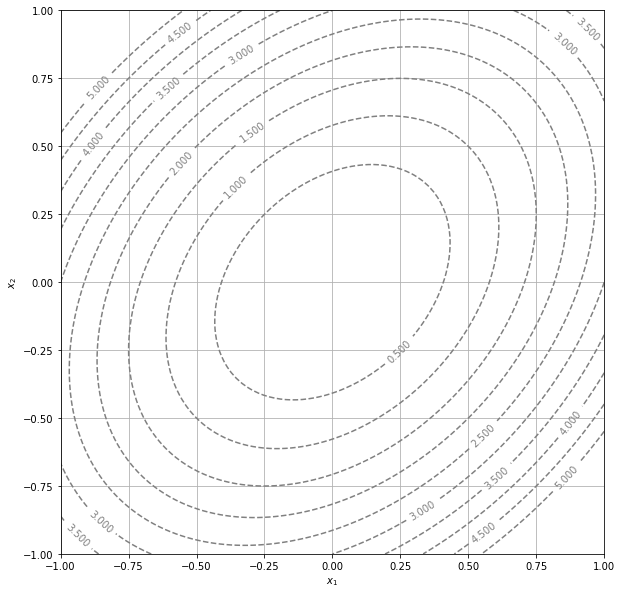

In [196]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels= np.linspace(0,5,11)
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [197]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

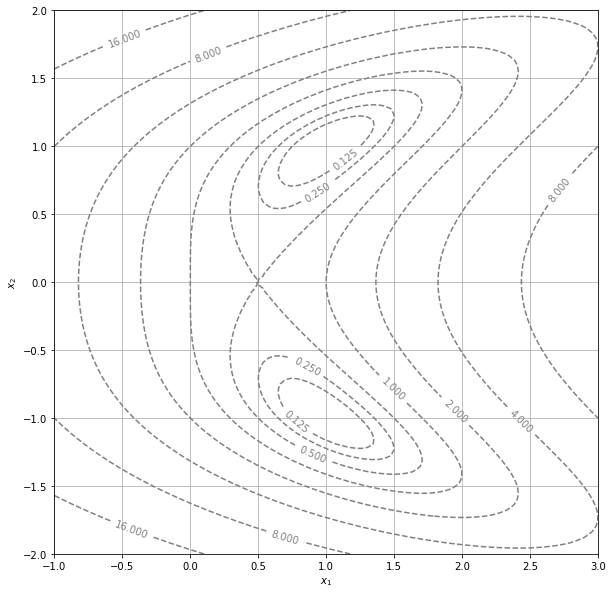

In [198]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [199]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

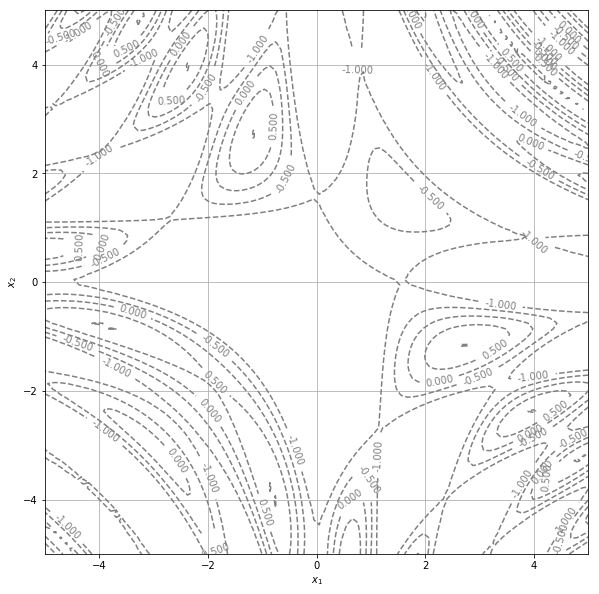

In [236]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels= np.linspace(-1,1,5) # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

__Réponse__ : L'ensemble de niveau c $E_c$ de $f$ est alors compact. En effet, il est déjà fermé en tant qu'ensemble de niveau : c'est $f^{-1}(\{c\})$ avec $\{c\}$ qui est un singleton, donc fermé ! De plus, on a $E_c$ qui est borné : comme $$\forall A \in \mathbb{R}, \exists M \in \mathbb{R}, \|x\| \geq M \implies f(x) \geq A$$ 

on a bien (en l'appliquant à $A=c+1$ par exemple) ce que l'on veut.

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

**Réponse** : On a le produit scalaire de $((x_{1}-x_{10}),(x_{2}-x_{20}))$ avec un vecteur normé, $$\frac{1}{\|\nabla f(x_0)\|}(\partial_2 f(x_0), -\partial_1 f(x_0))$$.
Or, celui-ci correspond à une rotation de -$\frac{\pi}{2}$ du gradient de f en $(x_{10}, x_{20})$ : on calcule donc la projection de $((x_{1}-x_{10}),(x_{2}-x_{20}))$ orthogonalement au gradient de f en $(x_{10}, x_{20})$.
Ainsi, si $p(x_1,x_2)$ est nul, c'est que $(x_1,x_2)$ est "dans la direction" du gradient en $(x_{10}, x_{20})$. $p$ est donc une projection du vecteur $((x_{1}-x_{10}),(x_{2}-x_{20}))$ sur la tangente "à droite du gradient" en $(x_{10},x_{20})$  de la courbe de niveau $f(x)=c$.

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

**Réponse** : Soit $g$ qui va de $\mathbb{R^{2}}\times\mathbb{R}$ dans $\mathbb{R^{2}}$,   qui à $((x_1,x_2),t)$ associe : 

$$g((x_1,x_2,t) = (f(x_1,x_2)-c, p(x_1,x_2)-t)$$ 

On a $g(x_0,0) = (0,0)$ clairement. De plus, $g$ est continûment différentiable car $f$ l'est et car $p$ n'est qu'un polynôme de $(x_1,x_2)$, donc ses dérivées partielles sont elles aussi toutes continues.

$\forall ((x_1,x_2),t) \in \mathbb{R^2}\times\mathbb{R}, \partial_r g ((x_1,x_2),t)=$
$\begin{pmatrix} (\partial_1 f(r)) & (\partial_2 f(r)) \\ (\partial_1 p(r)) & (\partial_2 p(r)) \end{pmatrix}$ avec $r= (x_1,x_2)$

D'où:

$ det(\partial_r g(r_0))= (\partial_1 f(r_0))(\partial_2 p(r_0))-(\partial_1 p(r_0))(\partial_2 f(r_0)) = -\|\nabla f(r_0)\| < 0$ car $\nabla f(r_0)\ne 0$.

 Comme $\partial_r g$ évaluée en $(r_0,0)$ est inversible, elle l'est sur un voisinage ouvert de $(r_0,0)$ (appelons le $W$ par exemple). Alors, par le théorème des fonctions implicites, dans un voisinage ouvert $V$ de $x_0$, dans un voisinage $\left]-\varepsilon,\varepsilon \right[$ de $0$ où $\varepsilon > 0$ et $V\times \left]-\varepsilon,\varepsilon\right]\subset W$, il existe bien une certaine fonction $\gamma$ continûment différentiable telle que $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(p(x_1,x_2))$.

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

**Réponse** : D'après le TFI, on a alors $$\gamma'(t) = -(\partial_{r}g(\gamma(t),t))^{-1} \cdot \partial_t g(\gamma(t),t)$$

   - On a $\partial_t g({\gamma(t)},t) = \begin{pmatrix} 0 \\ -1 \end{pmatrix}\ne 0$, or $(\partial_r g(\gamma(t),t))^{-1}$ est inversible, donc $ \gamma'(t)\ne0 $
   
   - On trouve $ \gamma'(t) = \begin{pmatrix} -\partial_2 f(\gamma(t)) \\ \partial_1 f(\gamma(t)) \end{pmatrix} $, donc $\gamma'(t)$ est bien orthogonal à$ \nabla f(\gamma(t))$ : leur produit scalaire est bien nul.


## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

**Réponse** : Non, car en dessous d'une certaine précision on ne pourra pas distinguer deux points sur les graphiques matplotlib : il faut une précision assurant que la réponse "réelle" et le point rendu se confondent sur un pixel de l'écran.
On pourra adapter en fonction des cas mais `eps = 1e-7` convient pour la plupart des fonctions, avec la taille d'affichage choisie.

In [201]:
N = 1000
eps = 1e-7

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [202]:
def Newton(F, x0, y0, eps=eps, N=N):
    x0, y0 = float(x0), float(y0)        
    for i in range(N):
        Q = J(F)(x0,y0)
        (x, y) = (x0, y0) - np.dot(np.linalg.inv(Q),F(x0, y0))
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

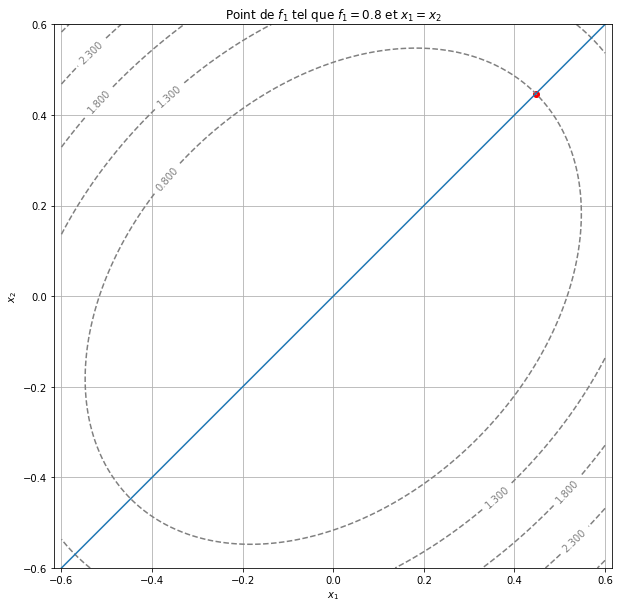

In [203]:
def f1_egalitaire(x1,x2):
    vect = (f1(x1, x2) - 0.8, x1-x2)
    vecto = np.array(vect)
    return vecto

n1 = Newton(f1_egalitaire,0.8,0.8)
X = list(n1)
display_contour(
    f1, 
    x=np.linspace(-0.6, 0.6, 100), 
    y=np.linspace(-0.6, 0.6, 100), 
    levels= [0.8] + np.linspace(0,5,11)
)
plt.scatter(X[0],X[1],c='r')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Point de $f_1$ tel que $f_1=0.8$ et $x_1=x_2$")
plt.grid(True)
plt.axis("equal")

L = np.linspace(-0.6,0.6,100)
plt.plot(L,L)
plt.show()


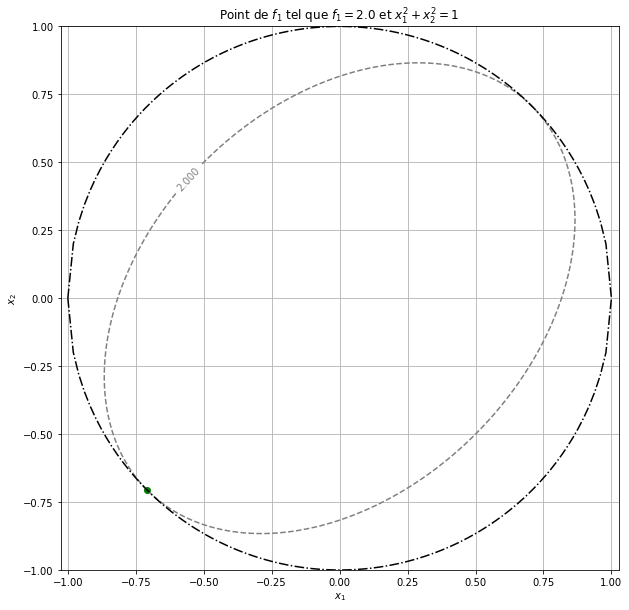

In [204]:
def f1_sommunit(x1,x2):
    vect = (f1(x1, x2) - 2.0, x1**2+x2**2-1)
    vecto = np.array(vect)
    return vecto

n2 = Newton(f1_sommunit,0.0,-0.3)
X = list(n2)
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels= [2.0] 
)
plt.scatter(X[0],X[1],c='g')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Point de $f_1$ tel que $f_1=2.0$ et $x_1^{2}+x_2^{2}=1$")
plt.grid(True)
plt.axis("equal")

def cerclunithaut(x):
    return np.sqrt(1-x**2)

def cerclunitbas(x):
    return -np.sqrt(1-x**2)

M = np.linspace(-1,1,100)
plt.plot(M,cerclunithaut(M),linestyle="-.",c='k')
plt.plot(M,cerclunitbas(M),linestyle="-.",c='k')
plt.show()


### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

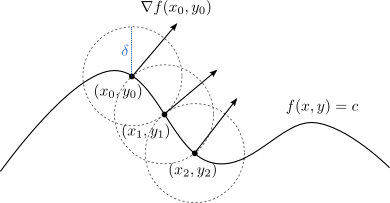

**Réponse** : On peut utiliser une méthode de Newton modifiée qui ajoute en plus comme contrainte que l'on renvoie $(x,y)$ seulement si celui-ci est à une distance $\delta > 0$ de $(x_0, y_0)$, c'est à dire que l'on veut qu'en plus $|\|(x, y) - (x_0, y_0)\| - \delta | \leq \varepsilon$ où $\varepsilon$ est l'epsilon machine. On ajoute ensuite la condition que de plus on doit avoir le point "à droite", c'est à dire qu'avec ce que l'on a défini plus haut,   $p(x_1, y_1) > 0$. Implémentons cela à présent !

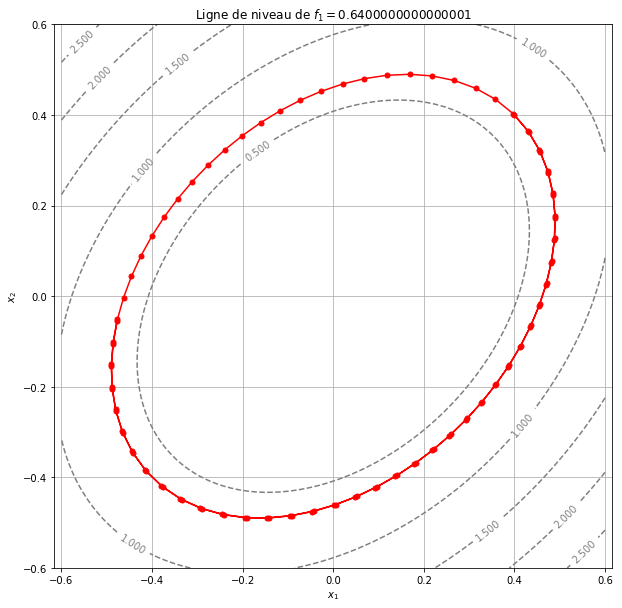

In [259]:
def level_curve(f, x0, y0, delta=0.01, N=1000, eps=eps):
    g = autograd.grad
    coord = np.zeros((2,N))
    coord[0,0], coord[1,0] = x0, y0
    c = f(x0, y0)
    def f_c(x1, x2):
        return f(x1, x2) - c
    for i in range(1, N):
        vect = np.dot(1/np.sqrt(g(f_c,0)(x0,y0)**2 + g(f_c,1)(x0,y0)**2),(g(f_c,1)(x0,y0), -g(f_c,0)(x0,y0)))
        a,b = x0,y0
        def F(x,y):
            vecti = np.array([
                f_c(x,y),
                (x - a)**2 + (y - b)**2 - delta**2
            ])
            return vecti
        (x0, y0) = (x0, y0) + np.dot(delta,vect)        
        x, y = Newton(F, x0, y0)
        coord[0,i], coord[1,i] = x, y
        x0, y0 = x, y
    return coord


X = level_curve(f1,0.4,0.4,0.05,100)
display_contour(
    f1, 
    x=np.linspace(-0.6, 0.6, 100), 
    y=np.linspace(-0.6, 0.6, 100), 
    levels=np.linspace(0,5,11)
)
plt.plot(X[0],X[1],c='r',marker='o',markersize=5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Ligne de niveau de $f_1={f1(0.4,0.4)}$")
plt.grid(True)
plt.axis("equal")

plt.show()

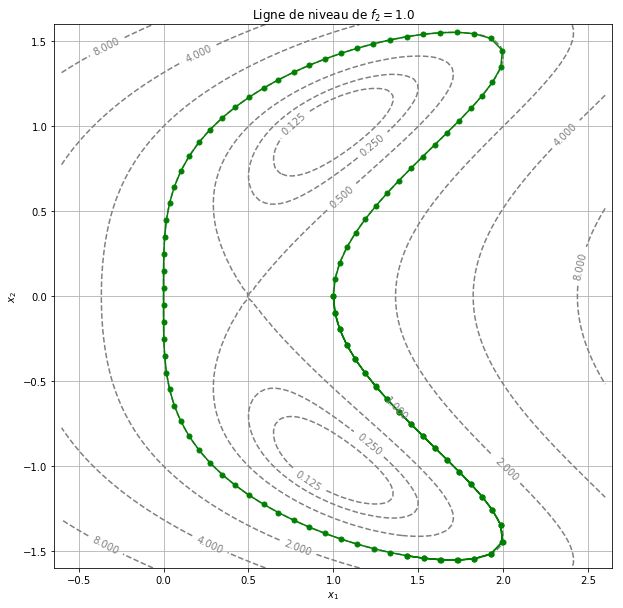

In [260]:
def f2_egalitaire(x1, x2):
    vect = np.array((f2(x1, x2) - 1.0,x1-x2))
    return vect

def f2_modif(x1,x2):
    return f2_egalitaire(x1,x2)[0]

start = (1.0,0.0)
X = level_curve(f2,start[0],start[1],0.1,120)
display_contour(
    f2, 
    x=np.linspace(-0.6, 2.6, 100), 
    y=np.linspace(-1.6, 1.6, 100), 
    levels= [2**i for i in range(-3, 8)] 
)
plt.plot(X[0],X[1],c='g',marker='o',markersize=5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Ligne de niveau de $f_2={f2(start[0],start[1])}$")
plt.grid(True)
plt.axis("equal")
plt.show()




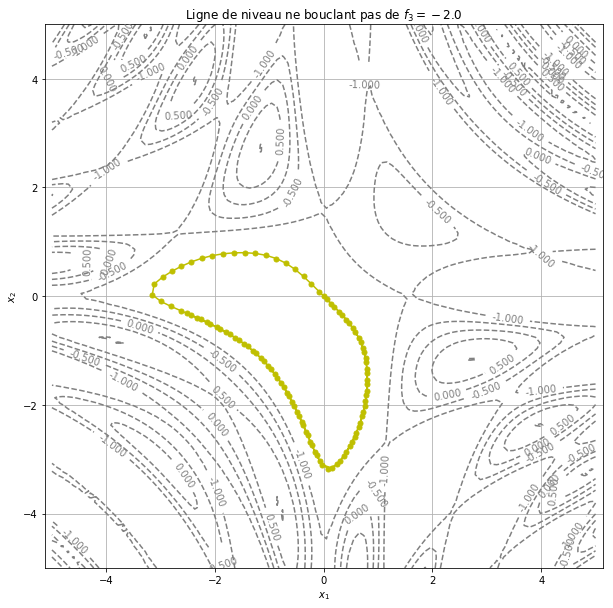

In [261]:
start = (0.0,0.0)
X = level_curve(f3,start[0],start[1],0.2,100)
display_contour(
    f3, 
    x=np.linspace(-5, 5, 100), 
    y=np.linspace(-5, 5, 100), 
    levels= np.linspace(-1,1,5)
)
plt.plot(X[0],X[1],c='y',marker='o',markersize=5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Ligne de niveau ne bouclant pas de $f_3={f3(start[0],start[1])}$")
plt.grid(True)
plt.axis("equal")
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

In [262]:
def level_curve_inter(f, x0, y0, delta=0.001, N=1000, eps=eps):
    g = autograd.grad
    coord = np.zeros((2,N))
    coord[0,0], coord[1,0] = x0, y0
    c = f(x0, y0)
    def f_c(x1, x2):
        return f(x1, x2) - c
    for i in range(1, N):
        vect = np.dot(1/np.sqrt(g(f_c,0)(x0,y0)**2 + g(f_c,1)(x0,y0)**2),(g(f_c,1)(x0,y0), -g(f_c,0)(x0,y0)))
        a,b = x0,y0
        def F(x,y):
            vecti = np.array([
                f_c(x,y),
                (x - a)**2 + (y - b)**2 - delta**2
            ])
            return vecti
        (x0, y0) = (x0, y0) + np.dot(delta,vect)        
        x, y = Newton(F, x0, y0)
        x0, y0 = x, y
        coord[0,i], coord[1,i] = x, y
        if i>=2:
            for k in range(0,i-1):
                segm1 = np.array((coord[0,k+1]-coord[0,k],coord[1,k+1]-coord[1,k]))
                segm2 = np.array((coord[0,i]-coord[0,k],coord[1,i]-coord[1,k]))
                cross = np.cross(segm1,segm2)
                if np.linalg.norm(cross) <= delta/10 and np.linalg.norm(segm1) >= np.linalg.norm(segm2) and np.dot(segm1,segm2) > 0:
                    return coord[::,0:i]
    return coord



**Réponse** : Ce que l'on sait, c'est qu'en tout point d'une ligne de niveau, le gradient de la fonction en ce point est orthogonal à la ligne de niveau (que ce soit vers "l'intérieur" ou "l'extérieur" de la ligne de niveau. Mais en un point où la courbe de niveau s'auto-intersecte, comment faire ?  En effet, on aurait alors deux expressions du gradient, selon si on le trouve par continuité en suivant une branche ou l'autre de la ligne de niveau... Prenons l'exemple de $f_2$, la fonction de Rosenbrock, pour la ligne de niveau $f_2 = 0.5$. On constate qu'il y aurait alors deux directions possibles pour le gradient par continuité. On en déduit qu'à ces points d'auto-intersection, le gradient de la fonction est nécessairement nul. (Preuve pour la fonction de Rosenbrock en $(0.5, 0)$ en fin de notebook). Mais alors, on ne peut appliquer Nexton au voisinage de ce point !

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

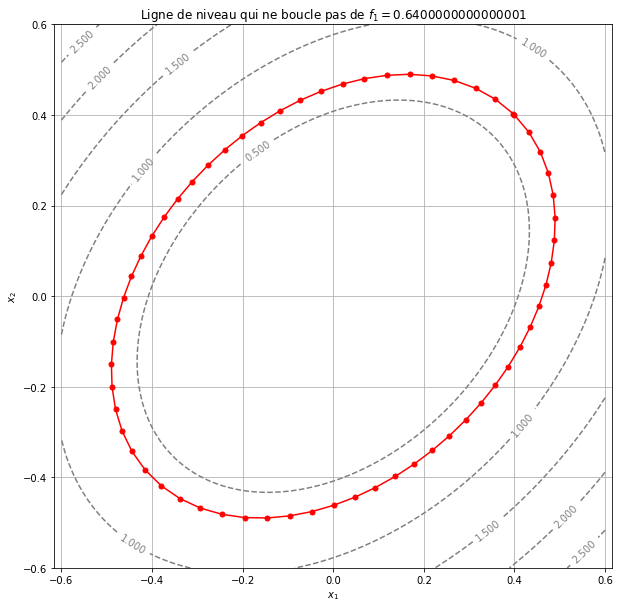

In [263]:
x0,y0 = (0.4,0.4)
X = level_curve_inter(f1,x0,y0,0.05,100)
display_contour(
    f1, 
    x=np.linspace(-0.6, 0.6, 100), 
    y=np.linspace(-0.6, 0.6, 100), 
    levels= np.linspace(0,5,11)
)
plt.plot(X[0],X[1],c='r',marker='o',markersize=5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Ligne de niveau qui ne boucle pas de $f_1={f1(x0,y0)}$")
plt.grid(True)
plt.axis("equal")
plt.show()

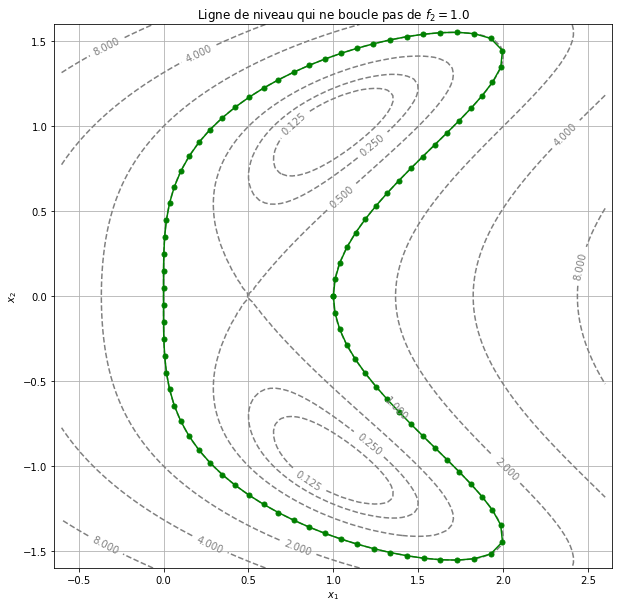

In [264]:
start = (1.0,0.0)
X = level_curve_inter(f2,start[0],start[1],0.1,150)
display_contour(
    f2, 
    x=np.linspace(-0.6, 2.6, 100), 
    y=np.linspace(-1.6, 1.6, 100), 
    levels= [2**i for i in range(-3, 8)] 
)
plt.plot(X[0],X[1],c='g',marker='o',markersize=5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Ligne de niveau qui ne boucle pas de $f_2={f2(start[0],start[1])}$")
plt.grid(True)
plt.axis("equal")
plt.show()

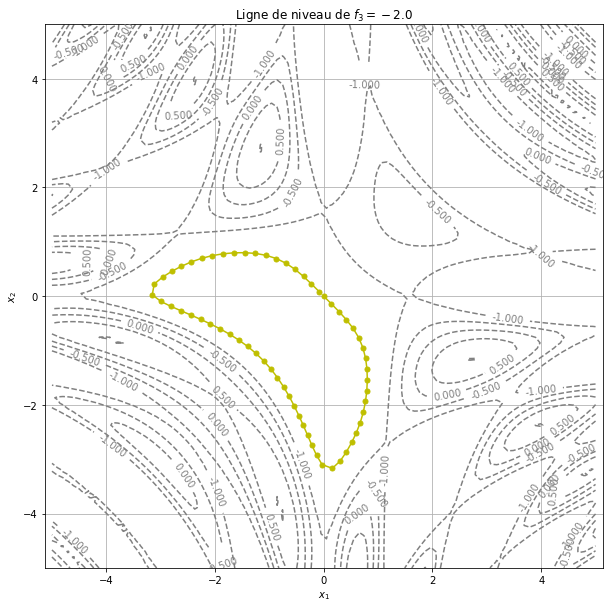

In [265]:
start = (0.0,0.0)
X = level_curve_inter(f3,start[0],start[1],0.2,100)
display_contour(
    f3, 
    x=np.linspace(-5, 5, 100), 
    y=np.linspace(-5, 5, 100), 
    levels= np.linspace(-1,1,5)
)
plt.plot(X[0],X[1],c='y',marker='o',markersize=5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Ligne de niveau de $f_3={f3(start[0],start[1])}$")
plt.grid(True)
plt.axis("equal")
plt.show()

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

**Réponse** : On suppose qu'une telle solution existe. On pose $P_1 = (x_1,y_1), P_2 = (x_2,y_2), u_1 = (u_{10},u_{11})$ et $u_2 = (u_{20},u_{21})$. Alors, on a :

- $\gamma(0) = P_1$ donc $a = x_1$ et $d = y_1$
- $\gamma(1) = P_2$ donc $a + b + c = x_2$ et $d + e + f = y_2$

En évaluant les dérivées, et en introduisant $\lambda > 0$ et $\mu > 0$ tels que $\gamma'(0) = \lambda*u_1$ et $\gamma'(1) = \mu*u_2$, comme $\gamma'(t) = (b + 2ct, e + 2ft)$ :

- $b = \lambda*u_{10}$ et $e = \lambda*u_{11}$
- $b + 2c = \mu*u_{20}$ et $e + 2f = \mu*u_{21}$

En réunissant ces équations, on obtient :
- $x_2 - x_1 - \lambda*u_{10} = c = \frac{1}{2}*(\mu*u_{20} - \lambda*u_{10})$, soit $x_2-x_1 = \frac{1}{2}*(\mu*u_{20} + \lambda*u_{10})$

Et de même $y_2-y_1 = \frac{1}{2}*(\mu*u_{21} + \lambda*u_{11})$. On isole $\mu$ des deux côtés :
$\frac{2*(x_2-x_1) -\lambda*u_{10}}{u_{20}} = \mu = \frac{2*(y_2-y_1) -\lambda*u_{11}}{u_{21}}$

D'où enfin : $$\lambda = \frac{\frac{2*(x_2-x_1)}{u_{20}} - \frac{2*(y_2-y_1)}{u_{21}}}{\frac{u_{10}}{u_{20}} - \frac{u_{11}}{u_{21}}}$$

On peut déduire le reste de fil en aiguille en connaissant $\lambda$. 

Pour que ces résultats soient vrais, on doit imposer certaines conditions à nos points et vecteurs :
- Déjà, on ne doit avoir aucune des composantes de $u_2$ nulles, pour que $\lambda$ soit bien défini. On ne doit pas non plus avoir $\frac{u_{10}}{u_{20}} = \frac{u_{11}}{u_{21}}$ c'est à dire que $u_1$ et $u_2$ soient colinéaires.
- Pour avoir $\lambda > 0$, on doit avoir $\frac{2*(x_2-x_1)}{u_{20}} \neq \frac{2*(y_2-y_1)}{u_{21}}$ ; et si par exemple le 1er est plus grand que le 2e, alors on doit aussi avoir $\frac{u_{10}}{u_{20}} > \frac{u_{11}}{u_{21}}$.
- En supposant que désormais $\lambda > 0$ : on doit vérifier que $\mu$ l'est aussi, en appliquant le même genre de contraintes.

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [266]:
def gamma(t,P1,P2,u1,u2):
    x1,y1 = P1[0],P1[1]
    x2,y2 = P2[0],P2[1]
    u10,u11 = u1[0],u1[1]
    u20,u21 = u2[0],u2[1]
    if u20==0 or u21==0 or np.cross(u1,u2)==0:
        vect = list((x1+t*(x2-x1),y1+t*(y2-y1)))
        return vect
    else:
        lambdax = (2*(x2-x1)/u20 - 2*(y2-y1)/u21)/(u10/u20 - u11/u21)
        mux = (2*(x2-x1)-lambdax*u10)/u20
        if lambdax <= 0 or mux <= 0:
            vect = list((x1+t*(x2-x1),y1+t*(y2-y1)))
            return vect
        else:
            a = x1
            b = lambdax*u10
            c = x2 - b - a
            d = y1
            e = lambdax*u11
            f = y2 - e - d
            x = a + b*t + c*t**2
            y = d + e*t + f*t**2
            vecto = list((x,y))
            return vecto
        
def vectogamma(L,P1,P2,u1,u2):
    Gamm = [gamma(t,P1,P2,u1,u2) for t in L]
    Gammo = np.array(Gamm)
    return Gammo

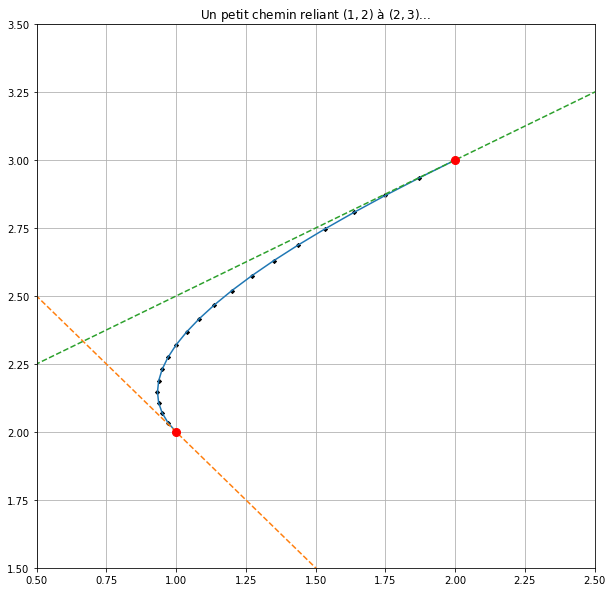

In [267]:
def gammader(t,P1,P2,u1,u2):
    x1,y1 = P1[0],P1[1]
    x2,y2 = P2[0],P2[1]
    u10,u11 = u1[0],u1[1]
    u20,u21 = u2[0],u2[1]
    if u20==0 or u21==0 or np.cross(u1,u2)==0:
        vect = list((x2-x1,y2-y1))
        return vect
    else:
        lambdax = (2*(x2-x1)/u20 - 2*(y2-y1)/u21)/(u10/u20 - u11/u21)
        mux = (2*(x2-x1)-lambdax*u10)/u20
        if lambdax <= 0 or mux <= 0:
            vect = list((x2-x1,y2-y1))
            return vect
        else:
            a = x1
            b = lambdax*u10
            c = x2 - b - a
            d = y1
            e = lambdax*u11
            f = y2 - e - d
            x = b + 2*c*t
            y = e + 2*f*t
            vecto = list((x,y))
            return vecto
    
T = np.linspace(0,1,21)
L = vectogamma(T,(1,2),(2,3),(-5,5),(2,1))
penteP1 = gammader(0,(1,2),(2,3),(-5,5),(2,1))
penteP2 = gammader(1,(1,2),(2,3),(-5,5),(2,1))

def tangP1(x):
    vectP1 = list((penteP1[0]*x+1.0,penteP1[1]*x+2.0))
    return vectP1

def tangP2(x):
    vectP2 = list((penteP2[0]*x+2.0,penteP2[1]*x+3.0))
    return vectP2

def tanglist(L,i):
    if i==1:
        M = []
        for x in L:
            M.append(tangP1(x))
        return np.array(M)
    elif i==2:
        N = []
        for x in L:
            N.append(tangP2(x))
        return np.array(N)
    else:
        pass

U = np.linspace(-2,2,41)
plt.scatter(L[::,0],L[::,1],s=8,marker='D',c='k')
plt.plot(L[::,0],L[::,1])
plt.plot(tanglist(U,1)[::,0],tanglist(U,1)[::,1],'--')
plt.plot(tanglist(U,2)[::,0],tanglist(U,2)[::,1],'--')
plt.plot([1.0],[2.0],'ro', markersize='8')
plt.plot([2.0],[3.0],'ro', markersize='8')
plt.title("Un petit chemin reliant $(1,2)$ à $(2,3)$...")
plt.xlim(0.5,2.5)
plt.ylim(1.5,3.5)
plt.grid()
plt.show()


### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [268]:
def level_curve_fin(f, x0, y0, delta=0.001, N=1000, eps=eps, oversampling=1):
    g = autograd.grad
    coord = [[x0, y0]]
    c = f(x0, y0)
    def f_c(x1, x2):
        return f(x1, x2) - c
    for i in range(1, N):
        vect = np.dot(1/np.sqrt(g(f_c,0)(x0,y0)**2 + g(f_c,1)(x0,y0)**2),(g(f_c,1)(x0,y0), -g(f_c,0)(x0,y0)))
        a,b = x0,y0
        def F(x,y):
            vecti = np.array([
                f_c(x,y),
                (x - a)**2 + (y - b)**2 - delta**2
            ])
            return vecti
        (x0, y0) = (x0, y0) + np.dot(delta,vect)        
        x, y = Newton(F, x0, y0)
        coord.append([x, y])
        x0, y0 = x, y
    if oversampling==1:
        coordo = np.array(coord)
        coordonnées = coordo.T
        return coordonnées
    else:
        coord = [coord[0]] + vectogamma(np.linspace(0,1,oversampling+1)[1:-1],tuple(coord[0]), tuple(coord[1]), (coord[1][0]-coord[0][0],coord[1][1]-coord[0][1]), (coord[1][0]-coord[0][0],coord[1][1]-coord[0][1])).tolist() + coord[1::]
        for i in range(1,N-2):
            coord = coord[0:oversampling*i+1] + vectogamma(np.linspace(0,1,oversampling+1)[1:-1],tuple(coord[oversampling*i]), tuple(coord[oversampling*i+1]), (coord[oversampling*i][0]-coord[oversampling*i-1][0],coord[oversampling*i][1]-coord[oversampling*i-1][1]), (coord[oversampling*i+2][0]-coord[oversampling*i+1][0],coord[oversampling*i+2][1]-coord[oversampling*i+1][1])).tolist() + coord[oversampling*i+1:]
        coord = coord[0:-1] + vectogamma(np.linspace(0,1,oversampling+1)[1:-1],tuple(coord[-2]), tuple(coord[-1]), (coord[-1][0]-coord[-2][0],coord[-1][1]-coord[-2][1]), (coord[-1][0]-coord[-2][0],coord[-1][1]-coord[-2][1])).tolist() + [coord[-1]]
        coordo = np.array(coord)
        coordonnées = coordo.T
        return coordonnées
            
        

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

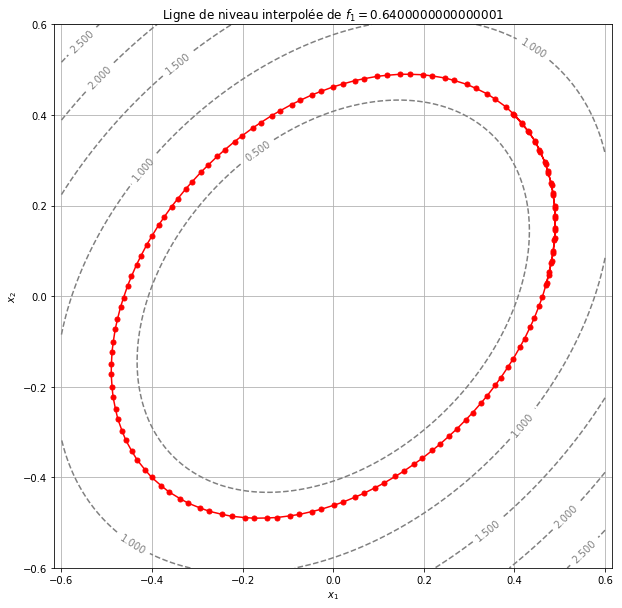

In [269]:
x0,y0 = (0.4,0.4)
X = level_curve_fin(f1,x0,y0,0.05,70,eps,2)
display_contour(
    f1, 
    x=np.linspace(-0.6, 0.6, 100), 
    y=np.linspace(-0.6, 0.6, 100), 
    levels= np.linspace(0,5,11) 
)
plt.plot(X[0],X[1],c='r',marker='o',markersize=5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Ligne de niveau interpolée de $f_1={f1(0.4,0.4)}$")
plt.grid(True)
plt.axis("equal")
plt.show()


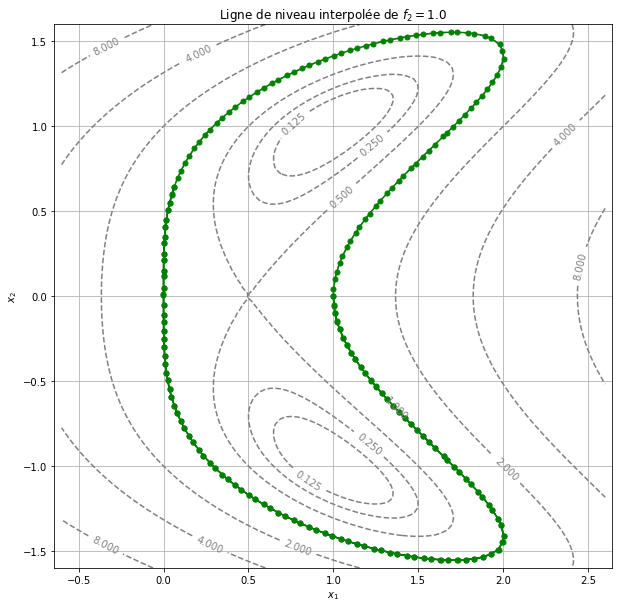

In [270]:
start = (1.0,0.0)
X = level_curve_fin(f2,start[0],start[1],0.1,150,eps,2)
display_contour(
    f2, 
    x=np.linspace(-0.6, 2.6, 100), 
    y=np.linspace(-1.6, 1.6, 100), 
    levels= [2**i for i in range(-3, 8)] 
)
plt.plot(X[0],X[1],c='g',marker='o',markersize=5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Ligne de niveau interpolée de $f_2={f2(start[0],start[1])}$")
plt.grid(True)
plt.axis("equal")
plt.show()

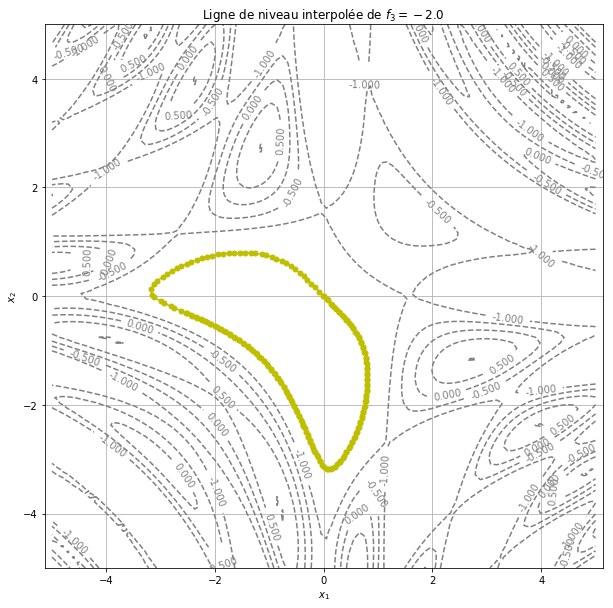

In [271]:
start = (0.0,0.0)
X = level_curve_fin(f3,start[0],start[1],0.2,100,eps,2)
display_contour(
    f3, 
    x=np.linspace(-5, 5, 100), 
    y=np.linspace(-5, 5, 100), 
    levels= np.linspace(-1,1,5)
)
plt.plot(X[0],X[1],c='y',marker='o',markersize=5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Ligne de niveau interpolée de $f_3={f3(start[0],start[1])}$")
plt.grid(True)
plt.axis("equal")
plt.show()

La fonction de Rosenbrock est $f(x_1, x_2) = (x_1-1)^2 + (x_1-x_2^2)^2$. On a alors $\partial_{x_1} f(x_1,x_2) = 2(x_1-1) + 2(x_1-x_2^2)$ et $\partial_{x_2} f(x_1,x_2) = -4x_2(x_1-x_2^2)$
Donc, $$\nabla f(x_1,x_2) = \begin{bmatrix}2(x_1-1) + 2(x_1-x_2^2)\\-4x_2(x_1-x_2^2)\end{bmatrix}$$

Mais alors, on a en $(0.5, 0)$, $\nabla f(0.5,0) = \begin{bmatrix}0\\0\end{bmatrix}$ : comme on s'y attendait.